In [35]:
beta = np.diff(infectRaw+recovRaw+deadRaw)/infectRaw[:-1] #scaling won't matter here, cancels out

In [37]:
cons = [len(infectRaw)]

def simulate(theta, cons):
    
    return theta
    
def randStart():
    theta = np.ones(6)

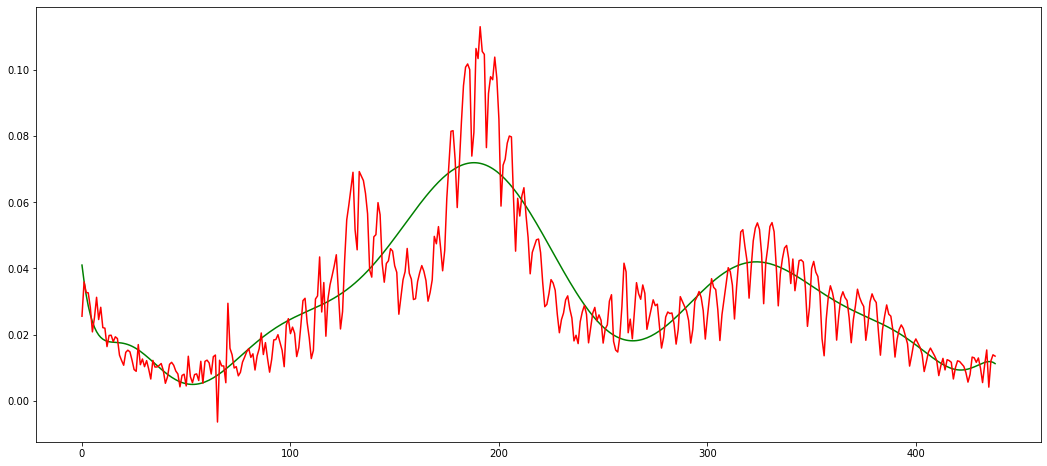

In [53]:
# from scipy.interpolate import lagrange
from numpy.polynomial import legendre
polyCount = 13 #degree of polynomial

timeSeries = np.arange(len(beta))
coef = legendre.legfit(timeSeries, beta, polyCount)

fitSeries = legendre.legval(timeSeries, coef)

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(timeSeries, fitSeries, color="green")
ax.plot(timeSeries, beta, color="red")

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import random

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradientDescent as gd


def startFunc(consts):
    
    #return ukVars
    
    recovRate = consts[0]
    deathRate = consts[1]
    
    params = np.zeros(7)
        
    params[0] = random.random()*.001 #I(0), between 0 and .1 percent of the population
    params[1] = random.random()*.1 #A(0), between 0 and 10 percent of the population
    
    params[2] = .1 + random.random()*10 #alpha0 knowledge rate [.001, 10.1]
    params[3] = .001 + random.random()*.05 #alpha1 knowledge decay rate [.001, .051]

    params[4] = (recovRate+deathRate) * random.random() #beta0, floor infection rate
    #theta[4] = 0
    params[5] = (recovRate+deathRate - params[4]) * (.5*random.random() + 1.1) #beta1, ceiling infectRate
    params[6] = .5 + random.random()*5 #beta2, exponential [.5, 5.5]
    
    return params
    
def simFunc(params, consts):
    
    recovRate = consts[0]
    deathRate = consts[1]
    dayNum = consts[2]
    
    I = np.zeros((dayNum))
    K = np.zeros((dayNum))

    I[0] = params[0] # I(0)
    K[0] = params[1]
    alpha0 = params[2]
    alpha1 = params[3]
    beta = params[4:] #beta0, beta1, beta2
    

    #iterate the arrays using the definition K' and I'
    for t in range(len(I)-1): #define I and K on range [1, length)
        diffI = (beta[0] + (beta[1] / (1 + (K[t])**beta[2] )) )*I[t] - (recovRate + deathRate)*I[t]
        diffK = alpha0*I[t] - alpha1*K[t]

        I[t+1] = diffI + I[t]
        K[t+1] = diffK + K[t]

    return I #I is the data generated

def constrainFunc(parameters, consts):
    
    params = np.copy(parameters)
    
    recovRate = consts[0]
    deathRate = consts[1]
    
    #fill the constraints
    paramConstraints = np.zeros((len(params),2)) #min, max for each one
    
    paramConstraints[0] = [.0000000001, .005] #I(t)
    paramConstraints[1] = [ 0.000000001, 10e10] #K(t), no real ceiling

    paramConstraints[2] = [0.00001, 10e10] #alpha0
    paramConstraints[3] = [0.00001, 1] #alpha1

    paramConstraints[4] = [0.0000001, recovRate + deathRate] #beta0 < recoveries
    paramConstraints[5] = [recovRate + deathRate - params[4], 20] #beta1, beta1+beta2 ceiling
    paramConstraints[6] = [.25, 10] #beta2
    
    for i in range(len(params)): #exercise each constraint
        params[i] = min( max(paramConstraints[i,0], params[i]) , paramConstraints[i,1])
    
    return params
    

## US Fit

In [139]:
dates, I, R, D, V = owid.LoadCountryNormal("United States") 

gradDesc.eta = 1
gradDesc.delta = .001

bestError = 100

for i in range(100):
    gradDesc = gd.GradDescent(I, [sird.getGamma(I,R), sird.getNu(I,D), len(I)], startFunc, simFunc, constrainFunc)
    gradDesc.solveVars(printOut=10000)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        usVars = gradDesc.params
        print(bestError)

Startin Vars:
Error: 0.009648570990662825
[4.66408163e-04 1.41268754e-03 5.17939622e+00 3.44130732e-02
 6.18993067e-03 9.57037685e-02 2.61254072e+00]
Iteration: 10000 Error: 0.004533875297566811 , improvement: 1.5162316871158913e-05
Iteration: 20000 Error: 0.004331842462093552 , improvement: 1.913679777132354e-06
Iteration: 30000 Error: 0.004253332094051734 , improvement: 1.7419474047944424e-06
Iteration: 40000 Error: 0.004184617231193937 , improvement: 1.5075151534161898e-06
Iteration: 50000 Error: 0.004127324048846773 , improvement: 1.2493089410985637e-06
Iteration: 60000 Error: 0.004081183541131245 , improvement: 1.003212705704408e-06
Iteration: 70000 Error: 0.004044915257295953 , improvement: 7.880845740393006e-07
Iteration: 80000 Error: 0.004016859910953109 , improvement: 6.102253248506406e-07
Iteration: 90000 Error: 0.003995368073552712 , improvement: 4.6841829090731543e-07
Iteration: 100000 Error: 0.003978988677474919 , improvement: 3.5794886078640883e-07
Iteration: 110000 Error

KeyboardInterrupt: 

[3.07896141e-05 1.17875219e-03 5.17983153e+00 2.81811596e-02
 1.27278242e-02 1.53039005e-01 2.61377973e+00]


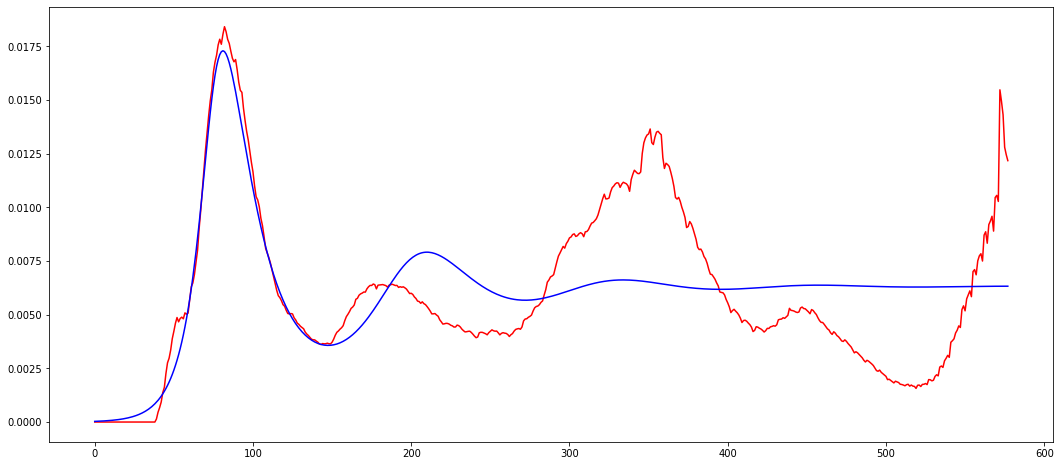

In [141]:
print(gradDesc.params)

fig, ax = plt.subplots(figsize=(18,8))

#gradDesc.params = usVars

gradDesc.x = gradDesc.simulate(gradDesc.params) #to ensure sim data is set if solve vars func was broken
#usVars = gradDesc.params

ax.plot(gradDesc.y, color="red")
ax.plot(gradDesc.x, color="blue")

## UK Fit

In [116]:
dates, I, R, D, V = owid.LoadCountryNormal("United Kingdom")

gradDesc.eta = .001
gradDesc.delta = .001

bestError = 100

for i in range(100):
    gradDesc = gd.GradDescent(I, [sird.getGamma(I,R), sird.getNu(I,D), len(I)], startFunc, simFunc, constrainFunc)
    gradDesc.solveVars(printOut=10000)
    
    if(gradDesc.getError() < bestError):
        bestError = gradDesc.getError()
        ukVars = gradDesc.params
        print(bestError)

Startin Vars:
Error: 3.017578612562477
[3.65960527e-04 8.34307469e-02 2.51579086e-01 4.05806582e-02
 2.16249113e-02 6.76180886e-02 4.05256468e+00]
0.13591302597248972
Startin Vars:
Error: 0.1778098740762209
[8.52954634e-04 9.22516980e-03 9.78266562e+00 1.36894671e-02
 5.05462774e-02 2.62551464e-02 1.80276902e+00]
Iteration: 10000 Error: 0.11042049084043902 , improvement: 2.898107315659923e-06
Iteration: 20000 Error: 0.10371843223974767 , improvement: 1.4143081048979966e-05
Iteration: 30000 Error: 0.08982121076264661 , improvement: 1.4352784741452242e-05
0.08794267310069295
Startin Vars:
Error: 0.18156338147879134
[3.19284679e-04 9.57439098e-03 4.13288025e+00 5.74711658e-03
 3.97458928e-02 4.13712694e-02 7.69306671e-01]
Iteration: 10000 Error: 0.10163646956480868 , improvement: 6.091444467139693e-06
Iteration: 20000 Error: 0.09377911108306983 , improvement: 1.0300566889108492e-05
Iteration: 30000 Error: 0.08253012822611758 , improvement: 1.5617263895926893e-05
0.0673612835270773
Startin

KeyboardInterrupt: 

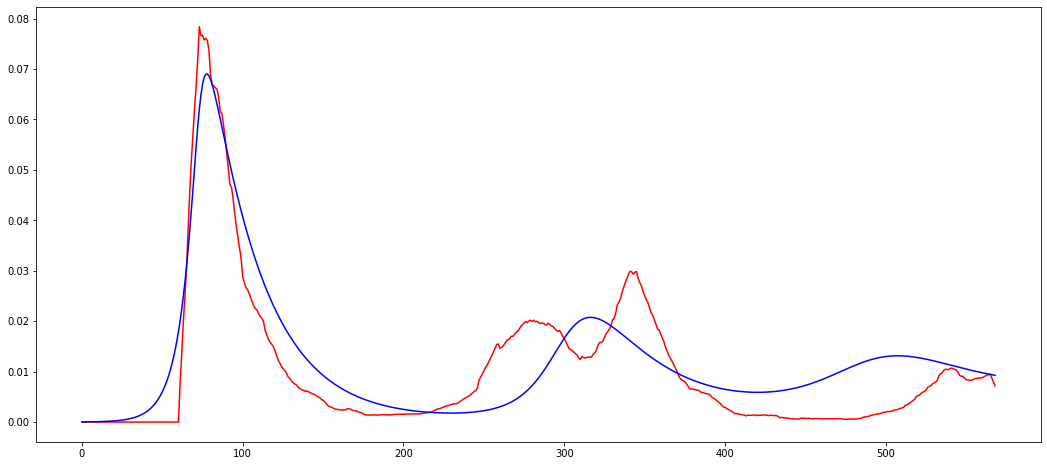

In [117]:
gradDesc.params = ukVars

gradDesc.x = gradDesc.simulate(gradDesc.params) #to ensure sim data is set if solve vars func was broken

#ukVars = gradDesc.params

fig, ax = plt.subplots(figsize=(18,8))

ax.plot(gradDesc.y, color="red")
ax.plot(gradDesc.x, color="blue")

<ipython-input-118-9a80b1327782>:2: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.diff(I+R+D)/I[:-1], color="red")
<ipython-input-118-9a80b1327782>:2: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(np.diff(I+R+D)/I[:-1], color="red")
<ipython-input-118-9a80b1327782>:4: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(np.diff(R+D)/I[:-1], color="green")


(0.0, 0.25)

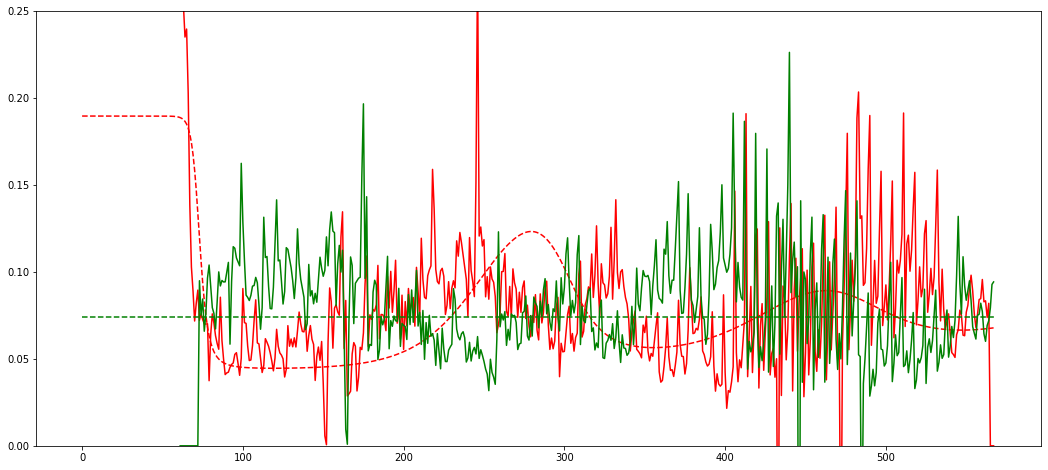

In [118]:
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(np.diff(I+R+D)/I[:-1], color="red")
ax.plot(  (np.diff(gradDesc.x) +  gradDesc.x[:-1]*(sird.getGamma(I,R)+sird.getNu(I,D)))/gradDesc.x[:-1], color="red", linestyle="dashed")
ax.plot(np.diff(R+D)/I[:-1], color="green")
ax.plot( np.ones(len(I))*(sird.getGamma(I,R)+sird.getNu(I,D)), color="green", linestyle="dashed" ) 

ax.set_ylim([0,.25])

In [142]:
print(ukVars)

[2.52925639e-05 4.42790066e-02 1.71288974e+00 1.22667337e-02
 4.34139659e-02 1.46153216e-01 4.09167577e+00]
